In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")

In [2]:
start_date = "2013-12-31"
end_date = "2023-12-31"


In [3]:
data = {}

ticker = yf.Ticker("WMT")

data['High'] = ticker.history(start = start_date, end = end_date)['High']
data['Low'] = ticker.history(start = start_date, end = end_date)['Low']
data['Close'] = ticker.history(start = start_date, end = end_date)['Close']
data['Volume'] = ticker.history(start = start_date, end = end_date)['Volume']

data = pd.DataFrame(data)

data.head()

,High,Low,Close,Volume
Date,,,,
2013-12-31 00:00:00-05:00,63.983084,63.561235,63.837063,3859100
2014-01-02 00:00:00-05:00,64.469853,63.682942,64.015526,6878000
2014-01-03 00:00:00-05:00,64.194014,63.699157,63.804630,4957400
2014-01-06 00:00:00-05:00,64.015539,63.106944,63.447670,7280200
2014-01-07 00:00:00-05:00,63.966865,63.212397,63.642361,5012300


In [4]:
import pandas_ta as ta

In [5]:
data['RSI'] = ta.rsi(data.Close, length = 14)
data['WPR'] = ta.willr(data.High, data.Low, data.Close, length = 14)
data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)
data['MACD'] = ta.ema(data.Close, length = 12) - ta.ema(data.Close, length = 26)

/var/folders/xm/_6m30k1j1kbgb2ps1nz6t4d00000gn/T/ipykernel_47478/2209731584.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['VWAP'] = ta.vwap(data.High, data.Low, data.Close, data.Volume, length = 14)


In [6]:
## Creating buy/sell trading signals using the indicator data to feed into the network
## for predicting the future stock price movement:

In [7]:
rsi_signal = []
for rsi in data['RSI']:
  if rsi > 70:
    rsi_signal.append(-1)
  elif rsi < 30:
    rsi_signal.append(1)
  else:
    rsi_signal.append(0)

data['RSI_signal'] = rsi_signal

wpr_signal = []
for wpr in data['WPR']:
  if wpr > -20:
    wpr_signal.append(-1)
  elif wpr < -80:
    wpr_signal.append(1)
  else:
    wpr_signal.append(0)

data['WPR_signal'] = wpr_signal

In [8]:
## Target Variable

In [9]:
data['TargetNextClose'] = data['Close'].shift(-1)
data.dropna(inplace = True)
data.reset_index(inplace = True)

data.head()

,Date,High,Low,Close,Volume,RSI,WPR,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,2014-02-06 00:00:00-05:00,59.391444,58.815451,59.075043,7353100,23.115523,-87.911913,59.093979,-1.572440,1,1,59.829517
1,2014-02-07 00:00:00-05:00,59.870059,58.815431,59.829517,7287600,35.182298,-64.077114,59.505003,-1.478448,0,0,59.837616
2,2014-02-10 00:00:00-05:00,59.837605,59.188627,59.837616,6204100,35.299682,-60.892118,59.621282,-1.387314,0,0,60.681313
3,2014-02-11 00:00:00-05:00,60.721856,59.764610,60.681313,6511200,46.225474,-19.168767,60.389260,-1.232799,0,-1,60.811127
4,2014-02-12 00:00:00-05:00,60.989587,60.210779,60.811127,5339800,47.689195,-14.056361,60.670497,-1.087335,0,-1,61.135624


In [10]:
data_set = data.iloc[:, 1:12]

pd.set_option('display.max_columns', None)

data_set.head()

,High,Low,Close,Volume,RSI,WPR,VWAP,MACD,RSI_signal,WPR_signal,TargetNextClose
0,59.391444,58.815451,59.075043,7353100,23.115523,-87.911913,59.093979,-1.572440,1,1,59.829517
1,59.870059,58.815431,59.829517,7287600,35.182298,-64.077114,59.505003,-1.478448,0,0,59.837616
2,59.837605,59.188627,59.837616,6204100,35.299682,-60.892118,59.621282,-1.387314,0,0,60.681313
3,60.721856,59.764610,60.681313,6511200,46.225474,-19.168767,60.389260,-1.232799,0,-1,60.811127
4,60.989587,60.210779,60.811127,5339800,47.689195,-14.056361,60.670497,-1.087335,0,-1,61.135624


In [11]:
## Feature Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_feature_train = MinMaxScaler(feature_range = (0, 1))
scaler_feature_test = MinMaxScaler(feature_range = (0, 1))
scaler_target_train = MinMaxScaler(feature_range = (0, 1))
scaler_target_test = MinMaxScaler(feature_range = (0, 1))

feature_set = data_set.drop(['TargetNextClose'], axis = 1)

target_set = np.array(data_set['TargetNextClose']).reshape(-1, 1)

In [13]:
splitlimit = int(len(feature_set) * 0.8)

feature_set_train, feature_set_test = feature_set[:splitlimit], feature_set[splitlimit:]
feature_set_train_scaled = scaler_feature_train.fit_transform(feature_set_train)
feature_set_test_scaled = scaler_feature_test.fit_transform(feature_set_test)

target_set_train, target_set_test = target_set[:splitlimit], target_set[splitlimit:]
target_set_train_scaled = scaler_target_train.fit_transform(target_set_train)
target_set_test_scaled = scaler_target_test.fit_transform(target_set_test)

In [14]:
## Constructing the dataset



In [15]:
X_train = []

backcandles = 14
features = 10

for i in range(features):
    X_train.append([])

    for j in range(backcandles, feature_set_train_scaled.shape[0]):
        X_train[i].append(feature_set_train_scaled[j-backcandles: j, i])

X_train = np.moveaxis(X_train, [0], [2])

X_test = []

for i in range(features):
    X_test.append([])

    for j in range(backcandles, feature_set_test_scaled.shape[0]):
        X_test[i].append(feature_set_test_scaled[j-backcandles: j, i])

X_test = np.moveaxis(X_test, [0], [2])

X_train, X_test = np.array(X_train), np.array(X_test)
Yi, Yj = np.array(target_set_train_scaled[backcandles:]), np.array(target_set_test_scaled[backcandles:]),
Y_train, Y_test = np.reshape(Yi, (len(Yi), 1)), np.reshape(Yj, (len(Yj), 1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1934, 14, 10)
(474, 14, 10)
(1934, 1)
(474, 1)


In [16]:
## Building and training the LSTM neural network

In [17]:
# Define your model
import tensorflow as tf
from tensorflow import keras

# Define your model
lstm_input = keras.layers.Input(shape=(backcandles, features), name='lstm_input')
lstm1 = keras.layers.LSTM(100, return_sequences=True, name='firstLSTM_layer')(lstm_input)
lstm2 = keras.layers.LSTM(75, name='secondLSTM_layer')(lstm1)
dense = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(lstm2)
dropout = keras.layers.Dropout(0.2)(dense)
out = keras.layers.Dense(1, name='output')(dropout)

model = keras.models.Model(inputs=lstm_input, outputs=out)

# Compile the model with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=adam, loss='mse', metrics=['mae'])

# Train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(x=X_train, y=Y_train, batch_size=15, epochs=100, shuffle=True, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, mae = model.evaluate(x=X_test, y=Y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")





Epoch 1/100
129/129 [==============================] - 3s 10ms/step - loss: 0.0597 - mae: 0.0677 - val_loss: 0.0416 - val_mae: 0.0700
Epoch 2/100
129/129 [==============================] - 1s 7ms/step - loss: 0.0286 - mae: 0.0470 - val_loss: 0.0287 - val_mae: 0.0858
Epoch 3/100
129/129 [==============================] - 1s 7ms/step - loss: 0.0166 - mae: 0.0409 - val_loss: 0.0174 - val_mae: 0.0612
Epoch 4/100
129/129 [==============================] - 1s 8ms/step - loss: 0.0115 - mae: 0.0413 - val_loss: 0.0131 - val_mae: 0.0572
Epoch 5/100
129/129 [==============================] - 1s 7ms/step - loss: 0.0081 - mae: 0.0379 - val_loss: 0.0159 - val_mae: 0.0863
Epoch 6/100
129/129 [==============================] - 1s 8ms/step - loss: 0.0061 - mae: 0.0360 - val_loss: 0.0105 - val_mae: 0.0628
Epoch 7/100
129/129 [==============================] - 1s 7ms/step - loss: 0.0047 - mae: 0.0334 - val_loss: 0.0098 - val_mae: 0.0627
Epoch 8/100
129/129 [==============================] - 1s 7ms/step -

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 14, 10)]          0         
                                                                 
 firstLSTM_layer (LSTM)      (None, 14, 100)           44400     
                                                                 
 secondLSTM_layer (LSTM)     (None, 75)                52800     
                                                                 
 dense (Dense)               (None, 64)                4864      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 102129 (398.94 KB)
Trainable params: 102129 (39

In [19]:
## Test Data Predictions

In [20]:
Y_pred = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


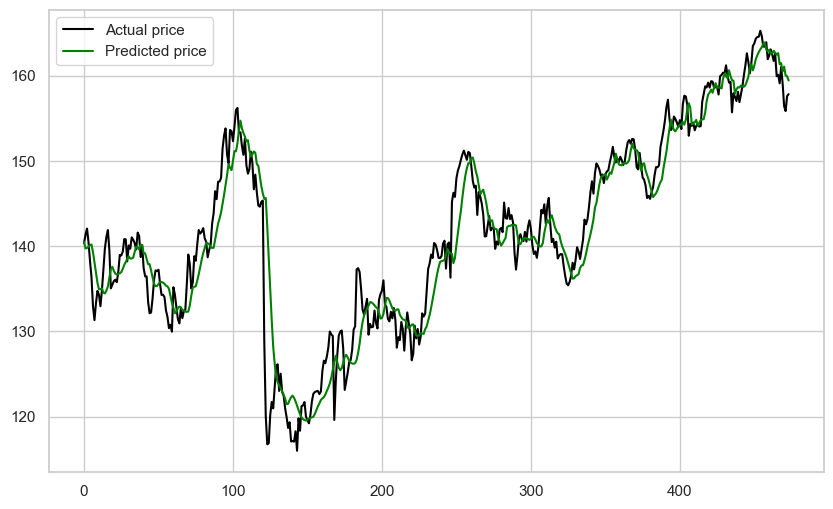

In [21]:
import matplotlib.pyplot as plt

# Inverse transform the scaled predictions to the original scale
Y_test_prices = scaler_target_test.inverse_transform(Y_test)
Y_pred_prices = scaler_target_test.inverse_transform(Y_pred)

# Plot the actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(Y_test_prices, color='black', label='Actual price')
plt.plot(Y_pred_prices, color='green', label='Predicted price')
plt.legend()
plt.show()

In [22]:
## Evaluation Metrics

In [23]:
## rmse (Root Mean Square Error)

In [24]:
rmse = np.round(np.sqrt(np.mean(((Y_test_prices[0] - Y_pred_prices[0])/Y_test_prices[0])**2)), 3)
print("Root Mean Square Error (RMSE) =", np.round(rmse*100, 3), "%")

Root Mean Square Error (RMSE) = 0.1 %


In [25]:
## Correlation

In [26]:
num_elements = Y_pred.shape[0]
print(num_elements)

474


In [27]:
num_elements = Y_test.shape[0]
print(num_elements)

474


In [28]:
predicted_values = Y_pred.ravel()
actual_values = Y_test.ravel()
correlation = np.corrcoef(actual_values, predicted_values)[0, 1]
print("Correlation between actual and predicted values:", correlation)

Correlation between actual and predicted values: 0.9486558783233883


In [29]:
## cointegration test

In [ ]:
import statsmodels.tsa.stattools as ts

# Perform the cointegration test
coint_result = ts.coint(Y_test_prices[0], Y_pred_prices[0], trend='c') 
 # Specify the trend parameter as 'c' (constant) or 'ct' (constant and trend)
p_val = coint_result[1]

print("P-Value for the cointegration test:")
print(np.round(p_val, 10))

## The cointegration test results in a P-value which is  0 ( Zero Division Error ) . 
## This indicates that the time series of the predicted prices and the actual prices are highly cointegration i.e. .
## they show a strong positive correlation over their duration .